# Baseline - Parametric model

Our baseline for this problem will be two parametric models called BG-NBD (Beta Geometric Negative Binomial Distribution) and Gamma-Gamma model.

The **BG-NBD** model estimates the purchase frequency and churn rate according to five assumptions:


1. While active, the number of transactions made by a customer follows a Poisson process. This is equivalent to assuming that the time between transactions is distributed exponential with transaction rate $\lambda$.
2. Heterogeneity in $\lambda$ follows a gamma distribution.
3. After any transaction, a customer becomes inactive with probability p.
4. Heterogeneity in p follows a beta distribution
5. The transaction rate $\lambda$ and the dropout probability p vary independently across customers.

In order to fit this model, four parameters are estimated using MLE (Maximum Likelihood Esimation). A detailed description of the method is available in [the original paper](http://brucehardie.com/papers/018/fader_et_al_mksc_05.pdf). 

After obtaining the expected frequency and churn rate for each customer, the **Gamma-Gamma** model is used to estimate the monetary value for each transaction. The combination of both models can be used to obtain the expected revenue for the next 3 months.

We will be using the lifetimes library for that. The results will be compared with our machine learning model in the next notebook.

In [1]:
#!pip install lifetimes

In [2]:
import io
import gc
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import sagemaker
import boto3

def read_parquet_s3(bucket, filepath):
    buffer = io.BytesIO()
    s3 = boto3.resource('s3')
    obj = s3.Object(bucket, filepath)
    obj.download_fileobj(buffer)
    return pd.read_parquet(buffer)

In [3]:
# build training set
train = read_parquet_s3("capstone-transaction-data",
                        "processed_data/train_features.parquet")
train_target = read_parquet_s3("capstone-transaction-data",
                               "preprocessed_data/train_target.parquet")
train = train.merge(train_target, on="id", how="left")
train["purchaseamount_90d"].fillna(0, inplace=True)

# build test set
test = read_parquet_s3("capstone-transaction-data",
                       "processed_data/test_features.parquet")
test_target = read_parquet_s3("capstone-transaction-data",
                              "preprocessed_data/test_target.parquet")
test = test.merge(test_target, on="id", how="left")
test["purchaseamount_90d"].fillna(0, inplace=True)

print(train.shape)
print(test.shape)
train.head()

(288081, 34)
(305007, 34)


,id,num_unique_date,max_transaction_amount,sum_amount,avg_transaction_amount,days_since_last_transaction,days_since_first_transaction,avg_daily_amount,unique_dates_to_days,unique_dates_180d,...,avg_transaction_amount_60d,purchasequantity_sum_60d,time_weighted_amount_60d,unique_dates_30d,transactions_count_30d,purchase_amount_sum_30d,avg_transaction_amount_30d,purchasequantity_sum_30d,time_weighted_amount_30d,purchaseamount_90d
0,12262064,120,65.959999,2295.729980,4.114212,1,213,10.778075,0.563380,109.0,...,4.053027,201.0,249.026154,19.0,93.0,337.389984,3.627849,102.0,140.975647,838.989990
1,12277270,93,24.980000,3601.310059,5.789887,2,210,17.149096,0.442857,81.0,...,5.808404,226.0,413.054291,12.0,116.0,660.409973,5.693190,144.0,299.235992,1505.689941
2,12332190,49,164.899994,1416.559937,5.169927,0,210,6.745523,0.233333,45.0,...,6.584206,141.0,210.490936,6.0,15.0,67.959999,4.530667,20.0,42.900917,1084.780029
3,12524696,70,21.990000,1581.670044,3.886167,3,213,7.425681,0.328638,61.0,...,3.849903,137.0,127.830322,8.0,57.0,242.279999,4.250526,74.0,88.039108,871.130005
4,12682470,73,36.990002,1578.010010,4.347135,3,213,7.408498,0.342723,63.0,...,4.988524,70.0,106.956429,13.0,41.0,196.849991,4.801219,48.0,78.548553,1113.880005


## 1 . Data wrangling

In order to fit the BG-NBD model we need a RFM data-structure (recency, frequency and monetary value):

- Frequency: Count of repeat time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase.

- T: Represents the age of the customer or the duration between a customer’s first purchase and the end of the period under study.
- Recency: Represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase.
- Monetary value: Represents the average value of a given customer’s purchases. This is equal to the sum of all a customer’s purchases divided by the total number of purchases. Note that the denominator here is different than the frequency described above.

In [4]:
def format_rfm_data(df):
    return pd.DataFrame({
        "frequency": df["num_unique_date"] - 1,
        "T": df["days_since_first_transaction"],
        "recency": df["days_since_first_transaction"] - df["days_since_last_transaction"],
        "monetary_value": df["sum_amount"] / df["num_unique_date"],
        "target": df["purchaseamount_90d"]
    })

train_rfm = format_rfm_data(train)
test_rfm =  format_rfm_data(test)
train_rfm.head()

,frequency,T,recency,monetary_value,target
0,119,213,212,19.131083,838.989990
1,92,210,208,38.723764,1505.689941
2,48,210,210,28.909386,1084.780029
3,69,213,210,22.595286,871.130005
4,72,213,210,21.616575,1113.880005


In [5]:
train_rfm.isin([None, np.nan, np.inf, -np.inf]).sum() # sanity check

frequency         0
T                 0
recency           0
monetary_value    0
target            0
dtype: int64

## 2. BG-NBD model and analysis

In [6]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(train_rfm['frequency'], train_rfm['recency'], train_rfm['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 288081 subjects, a: 0.00, alpha: 14.15, b: 17.44, r: 2.86>


In [7]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,2.860393,0.007986,2.844739,2.876046
alpha,14.146325,0.042577,14.062875,14.229776
a,0.002705,0.000299,0.002118,0.003291
b,17.435639,3.126237,11.308216,23.563063


The summary attribute shows the estimated parameters, the standard error and the confidence interval. We can also use the next function to plot the impact of the recency and frequency on the expected number of future purchases:

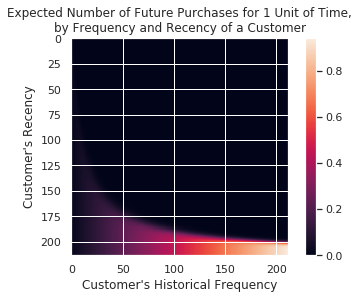

In [8]:
from lifetimes.plotting import plot_frequency_recency_matrix
_ = plot_frequency_recency_matrix(bgf)

The next plot shows the probability that the customer is alive (didnt churn) considering the recency and frequency. There is an interesting pattern here:

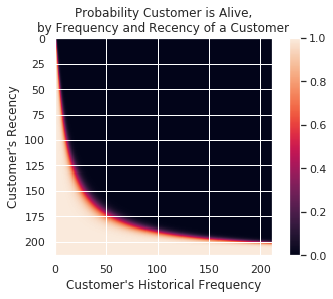

In [9]:
from lifetimes.plotting import plot_probability_alive_matrix
_ = plot_probability_alive_matrix(bgf)

It is also possible to compare our actual data versus artificial data simulated with our fitted model’s parameters:

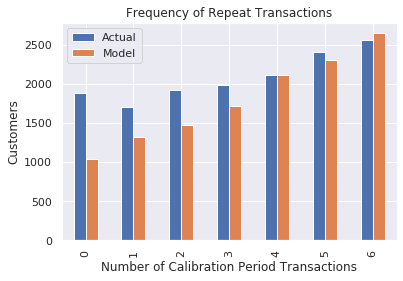

In [10]:
from lifetimes.plotting import plot_period_transactions
_ = plot_period_transactions(bgf)

## 3. Gamma-Gamma Model

The Gamma-Gamma submodel, assumes that there is no relationship between the monetary value and the purchase frequency. In practice we need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model.

In [11]:
train_rfm.loc[train_rfm.frequency > 0, ["frequency", "monetary_value"]].corr(method="pearson")

,frequency,monetary_value
frequency,1.000000,-0.227837
monetary_value,-0.227837,1.000000


We have low correlation therefore we can fit this model:

In [12]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef=0)
ggf.fit(train_rfm.loc[train_rfm.frequency > 0, "frequency"],
        train_rfm.loc[train_rfm.frequency > 0, "monetary_value"])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 286202 subjects, p: 0.36, q: 3.90, v: 451.46>


In [13]:
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,0.363120,0.004415,0.354466,0.371774
q,3.899856,0.019976,3.860703,3.939010
v,451.462024,7.766977,436.238750,466.685298


Finally we can estimate the customer revenue during the next 90 days. Note that we could also consider the time for each expected cashflow and discount that with a given rate to obtain a discounted cash flow. However, since we are using a small prediction window due to our limited data, we will leave the discount rate as zero and just sum the cash flows.

In [14]:
train_predictions = ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    train_rfm['frequency'],
    train_rfm['recency'],
    train_rfm['T'],
    train_rfm['monetary_value'],
    time=3, # months
    discount_rate=0.0 # monthly discount rate
)
test_predictions = ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    test_rfm['frequency'],
    test_rfm['recency'],
    test_rfm['T'],
    test_rfm['monetary_value'],
    time=3, # months
    discount_rate=0.0 # monthly discount rate
)
print(train_predictions.shape, test_predictions.shape)
train_predictions.head()

(288081,) (305007,)


0    1036.799257
1    1528.369216
2     670.551359
3     743.214081
4     744.206451
Name: clv, dtype: float64

## 4. Performance evaluation

Now how can we compare the results of this baseline with our machine learning model? There are many metrics to evaluate regression problems and the two most popular are probably the Mean Squared Error (MSE) and Root Mean Squared Error (RMSE). Another interesting metric is the Mean Absolute Percentage Error (MAPE), since this metric is easy to explain and to relate with the business problem in hand.

For this particular problem we need to consider a few important aspects:
- There can be many customers with zero purchase amount (churn)
- There is a long right tail for the target variable as seen in the previous notebook, including many outliers
- We are more interested in a relative error than the absolute error
- In general, for marketing decisions, underestimating the LTR is worse than overestimating it

The first point is a problem when using MAPE since the denominator will be zero. Both MSE and RMSE, as well as other metrics like Mean Absolute Error (MAE) doesn't have this problem, but are heavily affected by outliers. Therefore, the best metric considering all these points is the Root Mean Squared Log Error (RMSLE) that give us a relative error without much impact from outliers. It also has the property mentioned in the last point and is easy to calculate. A great article on this metric can be found at [this medium post](https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a).

In [17]:
from sklearn.metrics import mean_squared_log_error, mean_squared_error

def get_score(y_true, y_pred, metric="rmsle"):
    assert len(y_true) == len(y_pred)
    if metric == "rmsle":
        return np.sqrt(mean_squared_log_error(y_true, y_pred))
    elif metric == "rmse":
        return np.sqrt(mean_squared_error(y_true, y_pred))
    else:
        raise ValueError("Metric {} not available".format(metric))

train_score = get_score(train_rfm["target"], train_predictions, "rmsle")
test_score = get_score(test_rfm["target"], test_predictions, "rmsle")
print("Train RMSLE: {:.4f}, test RMSLE: {:.4f}".format(train_score, test_score))

Train RMSLE: 0.6403, test RMSLE: 0.6210


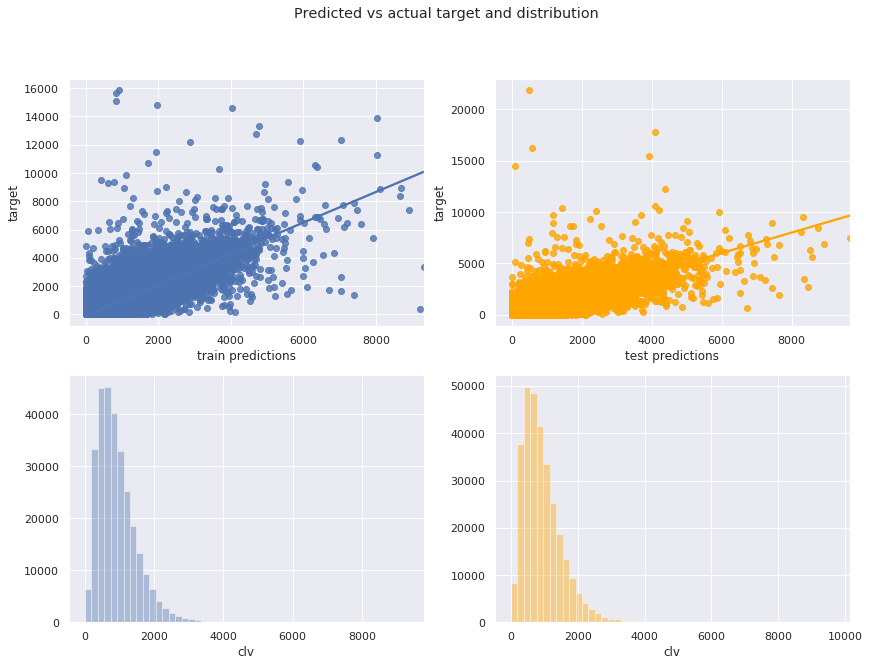

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
fig.suptitle('Predicted vs actual target and distribution')
sns.regplot(x=train_predictions, y=train_rfm["target"], ax=axes[0])
sns.regplot(x=test_predictions, y=test_rfm["target"],
            ax=axes[1], color="orange")
sns.distplot(train_predictions, kde=False, ax=axes[2])
sns.distplot(test_predictions, kde=False, ax=axes[3], color="orange")
_ = axes[0].set(xlabel='train predictions')
_ = axes[1].set(xlabel='test predictions')